## Import Libraries

In [1]:
import gym
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from stockstats import StockDataFrame as Sdf
from finrl.agents.stablebaselines3.models import A2C

from finrl.agents.stablebaselines3.models import DummyVecEnv


## Importing local modules

In [2]:
import os
import sys
sys.path.append('../')
from src.rl_env.stock import SingleStockEnv
from src.models.models import RLModels
from src.data.make_dataset import download_stock_data

In [3]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Download and save the data in a pandas DataFrame:
data_df = download_stock_data("GOOGL", start_date="2009-01-01", end_date="2020-10-23")

[*********************100%***********************]  1 of 1 completed


In [5]:
data_df

,date,open,high,low,close,adjcp,volume
0,2009-01-02,7.722723,8.053554,7.645145,8.041041,8.041041,144275580
1,2009-01-05,8.033033,8.289289,7.882883,8.209459,8.209459,195364440
2,2009-01-06,8.332833,8.528529,8.167918,8.359860,8.359860,256750992
3,2009-01-07,8.216216,8.281031,7.976727,8.058308,8.058308,179600220
4,2009-01-08,7.964965,8.137888,7.941441,8.137888,8.137888,143883972
...,...,...,...,...,...,...,...
2968,2020-10-16,78.091499,78.885498,77.883003,78.385002,78.385002,34194000
2969,2020-10-19,78.796501,79.196503,76.146004,76.497498,76.497498,29734000
2970,2020-10-20,76.155502,78.692001,76.025002,77.554001,77.554001,41670000
2971,2020-10-21,78.492500,80.757004,78.357002,79.299500,79.299500,60322000


In [6]:
data_clean = data_df.copy()

In [7]:
data_clean

,date,open,high,low,close,adjcp,volume
0,2009-01-02,7.722723,8.053554,7.645145,8.041041,8.041041,144275580
1,2009-01-05,8.033033,8.289289,7.882883,8.209459,8.209459,195364440
2,2009-01-06,8.332833,8.528529,8.167918,8.359860,8.359860,256750992
3,2009-01-07,8.216216,8.281031,7.976727,8.058308,8.058308,179600220
4,2009-01-08,7.964965,8.137888,7.941441,8.137888,8.137888,143883972
...,...,...,...,...,...,...,...
2968,2020-10-16,78.091499,78.885498,77.883003,78.385002,78.385002,34194000
2969,2020-10-19,78.796501,79.196503,76.146004,76.497498,76.497498,29734000
2970,2020-10-20,76.155502,78.692001,76.025002,77.554001,77.554001,41670000
2971,2020-10-21,78.492500,80.757004,78.357002,79.299500,79.299500,60322000


In [8]:
train = data_clean[(data_clean.date>='2009-01-01') & (data_clean.date<'2019-01-01')]
# the index needs to start from 0
train=train.reset_index(drop=True)
train['macd'] = 1

In [9]:
env_train = DummyVecEnv([lambda: SingleStockEnv(train, feat_list = ['adjcp', 'macd'])])
print("here",env_train.action_space.sample())
model = RLModels('a2c', env_train)
model.train(total_timesteps=100000)
model.save('AAPL_ppo_100k')


here [0.12275287]
previous_total_asset:100000
end_total_asset:288684.80407815275
total_reward:188684.80407815275
total_cost:  8518.862409554784
total trades:  2481
Sharpe:  0.7342148538424985
previous_total_asset:100000
end_total_asset:263789.7094669216
total_reward:163789.70946692157
total_cost:  8092.2988565381465
total trades:  2397
Sharpe:  0.6710145789109384
previous_total_asset:100000
end_total_asset:192307.8236625258
total_reward:92307.8236625258
total_cost:  7233.764648317405
total trades:  2315
Sharpe:  0.6321378902289093
previous_total_asset:100000
end_total_asset:341230.68524431105
total_reward:241230.68524431105
total_cost:  8751.242151400173
total trades:  2500
Sharpe:  0.7281584808110155
previous_total_asset:100000
end_total_asset:568904.9441430037
total_reward:468904.94414300367
total_cost:  9467.505660714327
total trades:  2514
Sharpe:  0.8684785920765085


KeyboardInterrupt: 

In [10]:
test = data_clean[(data_clean.date>='2019-01-01') ]
# the index needs to start from 0
test=test.reset_index(drop=True)

In [12]:
model = model_a2c
env_test = DummyVecEnv([lambda: SingleStockEnv(test, feat_list = ['adjcp', 'macd'])])
obs_test = env_test.reset()
print("==============Model Prediction===========")
for i in range(len(test.index.unique())):
    action, _states = model.predict(obs_test)
    obs_test, rewards, dones, info = env_test.step(action)
    env_test.render()

NameError: name 'model_a2c' is not defined

In [126]:
def get_DRL_sharpe():
    df_total_value=pd.read_csv('account_value.csv',index_col=0)
    df_total_value.columns = ['account_value']
    df_total_value['daily_return']=df_total_value.pct_change(1)
    sharpe = (252**0.5)*df_total_value['daily_return'].mean()/ \
    df_total_value['daily_return'].std()
    
    annual_return = ((df_total_value['daily_return'].mean()+1)**252-1)*100
    print("annual return: ", annual_return)
    print("sharpe ratio: ", sharpe)
    return df_total_value

In [133]:
df_total_value=pd.read_csv('account_value.csv',index_col=0)
df_total_value.columns = ['account_value']
df_total_value['daily_return']=df_total_value.pct_change(1)

In [137]:
df_total_value['daily_return'].mean()

0.001099399277741701

In [127]:


def get_buy_and_hold_sharpe(test):
    test['daily_return']=test['adjcp'].pct_change(1)
    sharpe = (252**0.5)*test['daily_return'].mean()/ \
    test['daily_return'].std()
    annual_return = ((test['daily_return'].mean()+1)**252-1)*100
    print("annual return: ", annual_return)

    print("sharpe ratio: ", sharpe)
    #return sharpe



In [128]:
df_total_value=get_DRL_sharpe()

annual return:  31.902975995593685
sharpe ratio:  0.8650235998059558


In [129]:
get_buy_and_hold_sharpe(test)

annual return:  32.96312299591686
sharpe ratio:  0.8814613447586216


In [130]:
DRL_cumulative_return = (df_total_value.account_value.pct_change(1)+1).cumprod()-1

In [131]:
buy_and_hold_cumulative_return = (test.adjcp.pct_change(1)+1).cumprod()-1

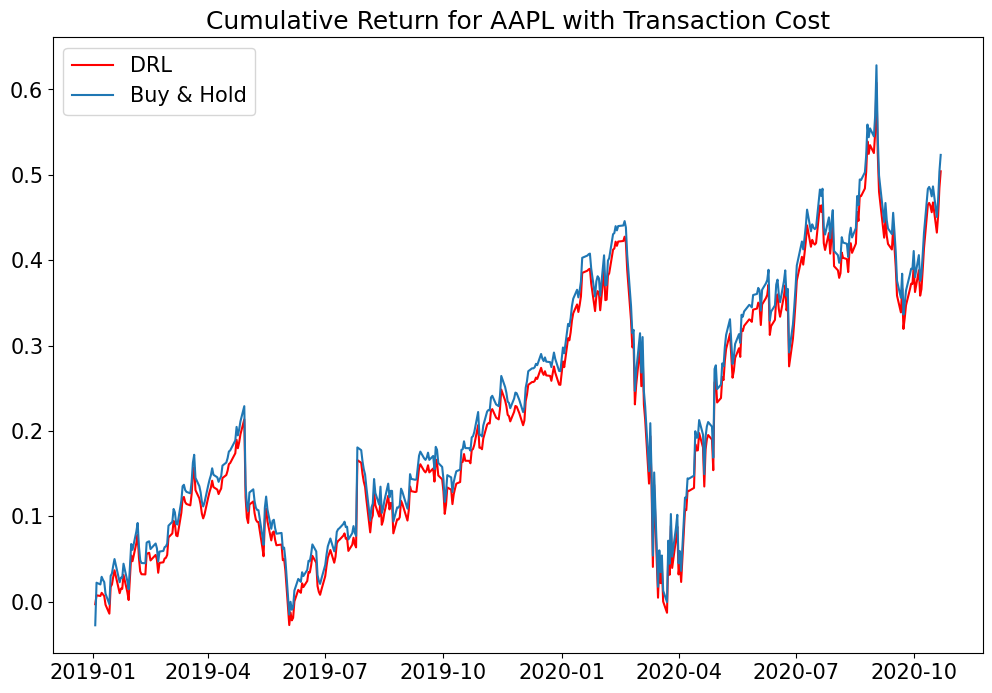

In [132]:


%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 8))

plt.plot(test.datadate, DRL_cumulative_return, color='red',label = "DRL")
plt.plot(test.datadate, buy_and_hold_cumulative_return, label = "Buy & Hold")
plt.title("Cumulative Return for AAPL with Transaction Cost",size= 18)
plt.legend()
plt.rc('legend',fontsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

